Install Dependencies

In [1]:
%pip install rocketlogger
%pip install pandas
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 69.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
ERROR: Exception:
Traceback (most recent call last):
  File "/home/kai/github/Ubicomp-Assignment01-Schultz/.venv/lib/python3.12/site-packages/pip/_internal/cli/base_command.py", line 105, in _run_wrapper
    status = _inner_run()
             ^^^^^^^^^^^^
  File "/home/kai/github/Ubicomp-Assignment01-Schultz/.venv/lib/python3.12/site-packages/pip/_internal/cli/base_command.py", line 96, in _inner_run
    return self.run(options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kai/github/Ubicomp-Assignment01-Schultz/.venv/lib/python3.12/site-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kai/github/Ubicomp-Assignment01-Schultz/.venv/lib/python3.12/site-packages/pip/_internal/commands/install.py", line 379, in r

Import dependencies and load data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import os
from numpy import linalg as LA
from rocketlogger.data import RocketLoggerData

ModuleNotFoundError: No module named 'rocketlogger'

In [15]:
# # Configuration
# Export figure settings
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['ps.useafm'] = True

# constants
LPM_CURRENT_THRESHOLD = 150e-6 # ampere
TRIM_START = 1.0 # seconds
TRIM_END = 1.0 # seconds
    
# input folder
input_folder = os.path.join('./')

# input files -- update path 
measurement_file = 'data/Onboard-data.rld'
# measurement_file = 'data/Offboard-data.rld'

# Load data
data = RocketLoggerData(os.path.join(input_folder, measurement_file))
data = data.merge_channels(True)
data_sample_rate = int(data._header['sample_rate'])
data_comment = data.get_comment()

In [16]:
# RAW DATA
I_app = data.get_data('I1').squeeze()[int(TRIM_START*data_sample_rate):-int(TRIM_END*data_sample_rate)]
V_app = data.get_data('V1').squeeze()[int(TRIM_START*data_sample_rate):-int(TRIM_END*data_sample_rate)]
app_active_window = data.get_data('DI1').squeeze()[int(TRIM_START*data_sample_rate):-int(TRIM_END*data_sample_rate)] > 0

print("Average supply voltage:  {:1.8f} mA ".format(1000*np.mean(I_app)))

Average supply voltage:  0.78844591 mA 


Extract application states

In [17]:
# TIME
t_app = data.get_time()[int(TRIM_START*data_sample_rate):-int(TRIM_END*data_sample_rate)]
t_app = t_app - t_app[0]
dt_app = np.hstack([np.diff(t_app), 0])

# POWER 
P_app = 1 * V_app * I_app

# Determine the start and end of task based on the digital signal
app_start = np.diff(np.hstack([[0], app_active_window])) > 0
app_start_index = np.nonzero(app_start)[0]
num_start = len(app_start_index)
# extract the end of button press
app_end = np.diff(np.hstack([[0], app_active_window])) < 0
app_end_index = np.nonzero(app_end)[0]
num_end = len(app_end_index)

print('Num. start signals recognized: ', num_start)
print('Num. stop signals recognized: ', num_end)

Num. start signals recognized:  73
Num. stop signals recognized:  73


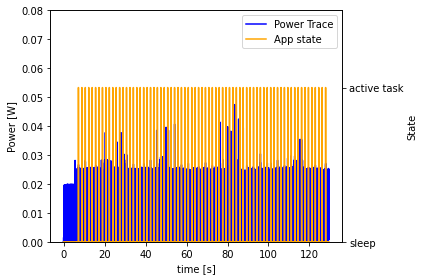

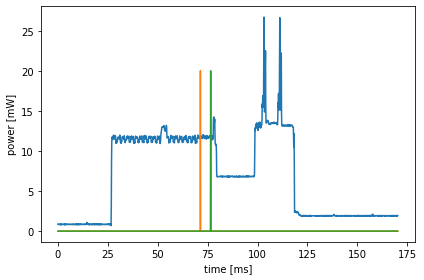

In [21]:
# plot the power trace and the calculated app state
fig, ax1 = plt.subplots()
lns1 = ax1.plot(t_app,P_app, label='Power Trace', color="blue")
plt.xlabel('time [s]')
plt.ylabel('Power [W]')
plt.ylim(0,0.08)
# second y axis
ax2 = ax1.twinx()
lns2 = ax2.plot(t_app,app_active_window, label='App state', color="orange")
ax2.set_ylim(0,1.5)
ax2.set_ylabel('State')
ax2.set_yticks([0, 1])
ax2.set_yticklabels( ["sleep", "active task"])
# add legends for both lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)
plt.tight_layout()
plt.savefig(measurement_file+"power_overview.png", bbox_inches="tight")

# # Plot the app start and app end 
# plt.figure()
# plt.plot(t_app,app_start, label='Start')
# plt.plot(t_app,app_end, label='End')
# plt.xlabel('time [s]')
# plt.ylabel('State')
# plt.yticks([0, 1], ["sleep", "active task"])
# plt.legend()
# plt.tight_layout()
# plt.savefig("state_overview.png", bbox_inches="tight")

# Print one activation  in detail
detail_range = range(190734,192092) # To be used with onboard file
# detail_range = range(193734,195092)
plt.figure()
_ = plt.plot(1e3 * (t_app[detail_range] - t_app[detail_range].min()), 1e3 * P_app[detail_range], label='Power Trace') 
_ = plt.plot(1e3 * (t_app[detail_range] - t_app[detail_range].min()), 20 * app_start[detail_range], label='Power Trace') 
_ = plt.plot(1e3 * (t_app[detail_range] - t_app[detail_range].min()), 20 * app_end[detail_range], label='Power Trace') 
_ = plt.xlabel('time [ms]')
_ = plt.ylabel('power [mW]')
plt.tight_layout()
plt.savefig(measurement_file+"closeup.png", bbox_inches="tight")
plt.show()

In [19]:
# calculate app active windows
app_active = np.zeros_like(app_start, dtype=bool)
app_active_index = np.zeros([num_start, 2], dtype=int)

for t in range(num_start):
    idx_start = app_start_index[t]
    idx_end = app_end_index[t]

    print("{}th Active time: {:1.4f} s".format(t+1, t_app[idx_end]-t_app[idx_start]))

1th Active time: 0.0051 s
2th Active time: 0.0053 s
3th Active time: 0.0051 s
4th Active time: 0.0053 s
5th Active time: 0.0053 s
6th Active time: 0.0053 s
7th Active time: 0.0051 s
8th Active time: 0.0053 s
9th Active time: 0.0051 s
10th Active time: 0.0051 s
11th Active time: 0.0051 s
12th Active time: 0.0051 s
13th Active time: 0.0053 s
14th Active time: 0.0053 s
15th Active time: 0.0053 s
16th Active time: 0.0053 s
17th Active time: 0.0053 s
18th Active time: 0.0053 s
19th Active time: 0.0053 s
20th Active time: 0.0053 s
21th Active time: 0.0053 s
22th Active time: 0.0053 s
23th Active time: 0.0051 s
24th Active time: 0.0053 s
25th Active time: 0.0053 s
26th Active time: 0.0051 s
27th Active time: 0.0053 s
28th Active time: 0.0053 s
29th Active time: 0.0053 s
30th Active time: 0.0053 s
31th Active time: 0.0053 s
32th Active time: 0.0053 s
33th Active time: 0.0053 s
34th Active time: 0.0051 s
35th Active time: 0.0053 s
36th Active time: 0.0051 s
37th Active time: 0.0053 s
38th Activ

Energy and time statistics

In [ ]:
# TODO: Calculate the energy consumed by each task


In [ ]:
# TODO: Calculate the execution time taken by each task